In [6]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib


#Downloading flower dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 172s 1us/step


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#Counting number of images

3670


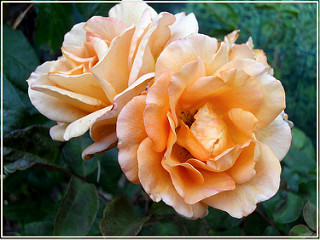

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Split the training and testing(validation) data into 80 and 20 percents respectively.

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

#Print all the types of flowers (classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


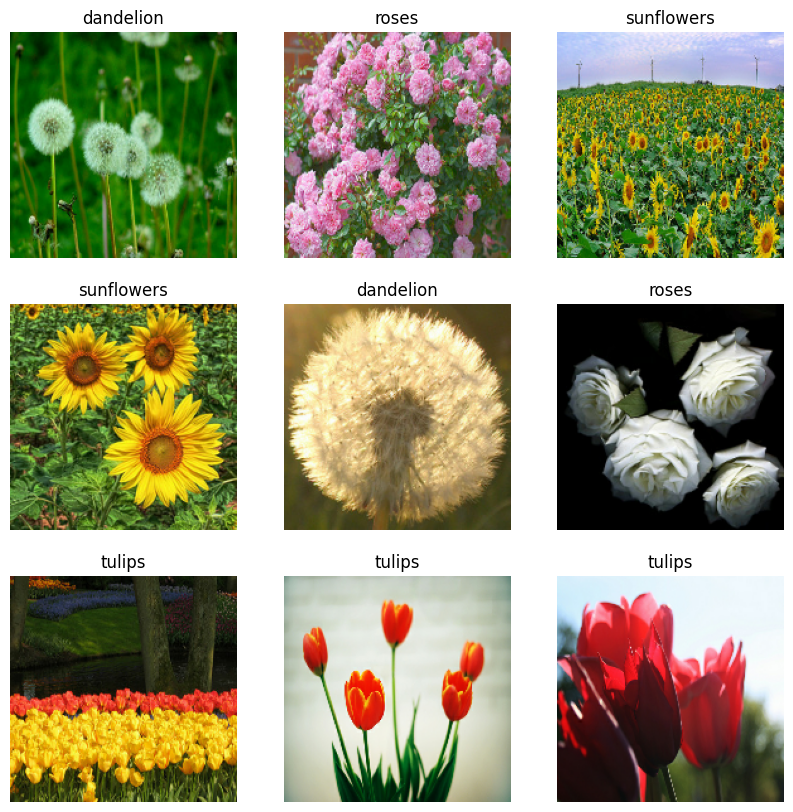

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
#See the data yourself
#This data is trainable using model.fit command, but we will see more methods to pre process the data
#Manually iterate over dataset and retrieve batches of images

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#RGB = [0,255], WE REDUCED IT TO [0,1] USING THIS COMMAND!

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image), np.mean(first_image))

0.0 1.0 0.3417104


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

#AUTOTUNE will prompt the tf. data runtime to tune the value dynamically at runtime :) 
#this is why tensors are used

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Read notes for .cache and .prefetch commands info

In [27]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='Adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [29]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 18s 188ms/step - loss: 1.3247 - accuracy: 0.4329 - val_loss: 1.0964 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 17s 187ms/step - loss: 1.0063 - accuracy: 0.5974 - val_loss: 0.9891 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 16s 179ms/step - loss: 0.8059 - accuracy: 0.6924 - val_loss: 0.9146 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 16s 175ms/step - loss: 0.6202 - accuracy: 0.7670 - val_loss: 1.0310 - val_accuracy: 0.6172
Epoch 5/10
92/92 [==============================] - 16s 175ms/step - loss: 0.4786 - accuracy: 0.8198 - val_loss: 1.2814 - val_accuracy: 0.6063
Epoch 6/10
92/92 [==============================] - 17s 184ms/step - loss: 0.3489 - accuracy: 0.8764 - val_loss: 1.4252 - val_accuracy: 0.6049
Epoch 7/10
92/92 [==============================] - 17s 186ms/step - loss: 0.3286 - accuracy: 0.8879 - val_loss: 1.5516 - val_accuracy: 0.5668

In [30]:
#We can see that the training accuracy is greater than the validation accuracy- indicating overfitting :(

In [31]:
#Using tf.data for very fine control


list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [33]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/natsu/.keras/datasets/flower_photos/tulips/130684927_a05164ba13_m.jpg'
b'/Users/natsu/.keras/datasets/flower_photos/tulips/402525114_eaa60c8341_m.jpg'
b'/Users/natsu/.keras/datasets/flower_photos/tulips/11746548_26b3256922_n.jpg'
b'/Users/natsu/.keras/datasets/flower_photos/daisy/10466558316_a7198b87e2.jpg'
b'/Users/natsu/.keras/datasets/flower_photos/roses/8742493617_c2a9bf854f_m.jpg'


In [34]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [35]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [36]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [37]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [39]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  4


In [40]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

2023-02-15 12:50:01.051735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


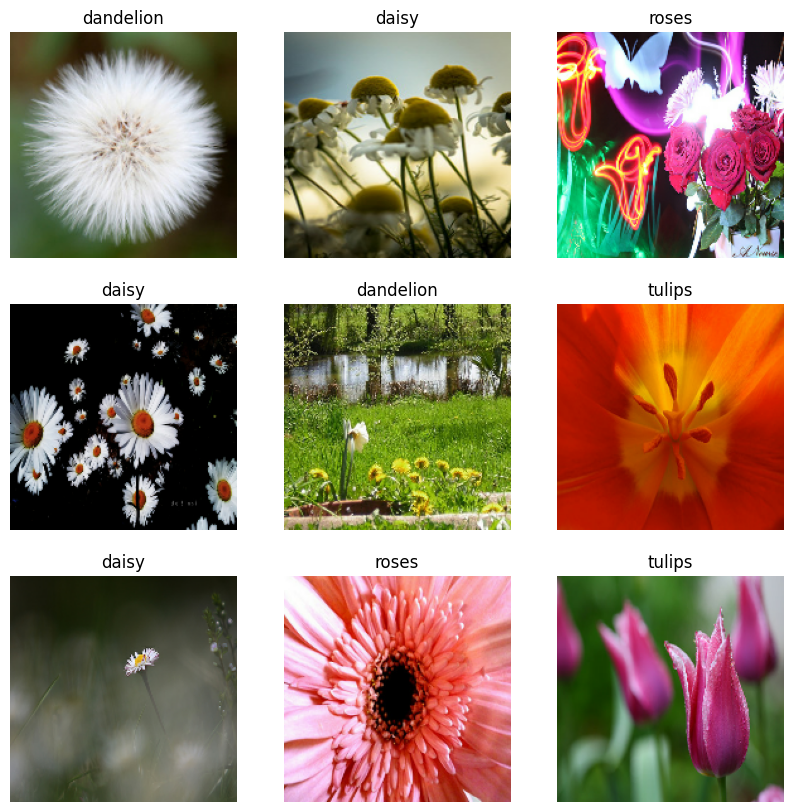

In [41]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [42]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 17s 183ms/step - loss: 0.3636 - accuracy: 0.9009 - val_loss: 0.4235 - val_accuracy: 0.8924
Epoch 2/3
92/92 [==============================] - 16s 169ms/step - loss: 0.1237 - accuracy: 0.9683 - val_loss: 0.4246 - val_accuracy: 0.9005
Epoch 3/3
92/92 [==============================] - 16s 171ms/step - loss: 0.0505 - accuracy: 0.9881 - val_loss: 0.5055 - val_accuracy: 0.8774


In [43]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2023-02-15 12:52:27.569552: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|█████████████████████████| 5/5 [02:32<00:00, 30.52s/ file]

Dataset tf_flowers downloaded and prepared to /Users/natsu/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [44]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2023-02-15 12:55:07.058066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


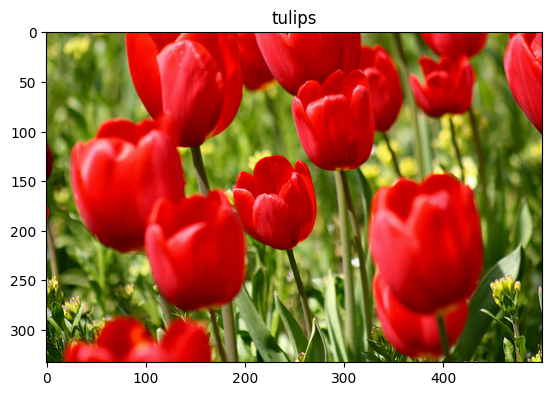

In [45]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [46]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

#THIS LAST PART WAS A TUTORIAL TO USE TF.DATASETS INSTEAD OF LOADING DATA OFF_DISK